In [1]:
#! -*- coding: utf-8 -*-

# マルコフ連鎖モンテカルロ法の紹介

In [2]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


CBCパラメータ推定講義では、検出された重力波信号を記述するシステムパラメータの確率密度分布を記述する*事後確率密度*について議論した。 典型的なブラックホールバイナリマージャーは、一般相対性理論の15のパラメータで記述される：ブラックホールの質量2、ブラックホールのスピンの大きさ、ブラックホールのスピンの方向4、バイナリの軌道の向きを決める2つの角度、 システム、輝度距離、および衝突の相および時間を含む。

パラメタ推定のチュートリアル[tutorial](https://git.ligo.org/jonah-kanner/odw-2018/blob/master/parameter_estimation/Calculating%20a%20Posterior%20Probability%20Density%20Function.ipynb) ソースの最もプロバブルなパラメータを得るために、事後密度をどのように*最大化*できるかについて議論した。 ここでは、これらのパラメータで誤差を取得する方法について説明します。

事後関数高い次元（15D）の為に、グリッドまたはモンテカルロ法の計算法はほぼ不可能である。 LVCは、この多次元分布をサンプリングするために2つの主な技術、すなわちマルコフ連鎖モンテカルロ（MCMC）とネステッドサンプリングを使用する。今回は前者を説明する。
詳しくは[ここ](https://arxiv.org/abs/1409.7215)を見てください

## マルコフ連鎖モンテカルロ - メトロポリスヘイスティングス

*Markov Chain*は、各サンプルが直前のサンプルのみに依存する事前定義された確率分布からのランダムサンプルの順序付けられたシーケンスです。 マルコフ連鎖を生成する様々なアルゴリズムが存在する。 Metropolis-Hastingsアルゴリズムを使用します。

Metropolis-Hastingsアルゴリズム：事前確率密度関数$P(x)$からサンプルを描画する

* 前回のサンプル$ x $を使って新しいサンプル$ y $を描画するには、 "プロポーザル密度" $Q(y|x)$を選択します。
* $P(y)\geq P(x)$の場合は、新しいサンプルを採用する
* $ P(y)<P(x)$の場合は、新しいサンプルを確率$(P(y)/P(x))(Q(x|y)/Q(y|x))$で採用する
* サンプルが採用されなかった場合、古いサンプルが繰り返されます
* $P$の正規化は関係ありません。 ベイズの定理のでは、これはエビデンスと言われます

In [3]:
#Propose a new step (using a symmetric Gaussian proposal density centered at the old sample)
def ProposedStep(oldsamp,sigmaprop,D):
    newsamp = oldsamp + np.random.normal(0.,sigmaprop,D)
    return newsamp

#Hastings ratio
def HastingsRatio(newsamp,oldsamp,priorrange,PDF,*Pargs):
    if not ((np.array([p1 - p2 for p1, p2 in zip(newsamp, np.transpose(priorrange)[:][0])])>0).all() \
            and (np.array([p2 - p1 for p1, p2 in zip(newsamp,np.transpose(priorrange)[:][1])])>0).all()):
        acc = False
        return acc, oldsamp # make sure the samples are in the desired range
    newprob = PDF(newsamp,*Pargs)
    oldprob = PDF(oldsamp,*Pargs)
    if newprob >= oldprob:
        acc = True
        return acc, newsamp
    else:
        prob = newprob/oldprob
        acc = np.random.choice([True,False],p=[prob,1.-prob])
        return acc, acc*newsamp + (1. - acc)*oldsamp 

#Function that runs the chain
def MCMC(PDF,D,Nsteps,priorrange,sigmaprop,*Pargs):
    #Draw a random starting point
    oldsamp=np.array([np.random.uniform(priorrange[d][0],priorrange[d][1]) for d in range(D)])
    
    #Count the number of accepted samples
    count = 0 
    
    #Store all samples
    samples = [oldsamp]
    
    for i in range(Nsteps):
        newsamp = ProposedStep(oldsamp,sigmaprop,D) #Propose a new sample
        acc, newsamp = HastingsRatio(newsamp,oldsamp,priorrange,PDF,*Pargs) #decide whether or not to accept it
        samples.append(newsamp) #Add the sample to the list of samples
        if acc:
            count += 1
        oldsamp = newsamp #Move to the new sample
        
    #compute the acceptance ratio    
    AR = 1.*count/Nsteps 
    return np.array(samples), AR


## 簡単シグナル

MCMC法を用いても、ブラックホールバイナリのパラメータに対する完全な15次元の事後密度関数からサンプリングすることは、非常に計算量が多い（数日から数週間）ことがあります。 ここでは、振幅、周波数、および初期位相の正弦波であるシミュレートされた信号を使用した、より単純な3次元問題について説明します。

我々のデータは、

$$d = A\ cos(f t+\phi) + n,$$

ここで、 $A\ cos(f t+\phi)$ は我々の信号、 $n$ は観測の際のノイズである。 

いくつかの測定値があり、誤差はガウス分布に従い（重力波検出器のノイズについて、我々はそう仮定する）それぞれ独立シゲいる（これは検出器ノイズが定常的であることに相当します）と仮定します。

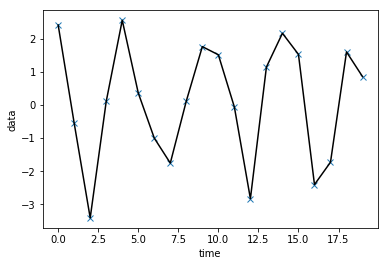

In [4]:
#Simulate a set of Nobs observations
Nobs = 20
sigma = 1 #the standard deviation of the Gaussian noise, equivalent to the PSD of the detector

#fix the true values of the parameters
A = 2. 
f = 4.*2.*np.pi/Nobs
phi = 1.

#Create a noise realizations
np.random.seed(10)
n = np.random.normal(0.,sigma,Nobs)

#Observation times
t = np.arange(Nobs)

#Generate the data
data = A*np.cos(f*t+phi) + n

#Try analyzing data without noise
#data = A*np.cos(f*t+phi) 

plt.plot(data,'x')
plt.plot(data,'k')
plt.xlabel('time')
plt.ylabel('data')
plt.show()

事後密度関数は、事前確率と尤度の積に比例する。 雑音はガウス的であるので、尤度は、既知の標準偏差（雑音の標準偏差）を有するガウス関数である。

In [5]:
# model for the signal
def model(A,f,phi,t):
    return A*np.cos(f*t+phi)

def posterior(samp,d,t):
    x = samp[0] # amplitude
    y = samp[1] # freuency
    z = samp[2] # phase
    
    res = (d-model(x,y,z,t))**2 # residual
    
    likelihood = np.exp(-0.5*(res.sum()/sigma**2)) 
    # sigma here is the standard deviation of the noise which we assume 
    #we know, similar to the PSD of the gravitational wave detector
    
    prior=1 #Let's assume uniform priors for all parameters
    
    # Change the form of the prior and reanalyze the data. For example use the following prior for the amplitude
    #prior= 1./x
    
    
    return prior*likelihood

事後確率によってからサンプルを抽出する

In [6]:
np.random.seed(10)
Nsteps = 200000 # length of the chain
sigmaprop = 0.09 # standard deviation of the proposal density
D=3 # dimensionality of the problem
priorrange=np.array([[0,5],[0,np.pi],[0,np.pi]])
samples, AR = MCMC(posterior,D,Nsteps,priorrange,sigmaprop,data,t) # run the chain
print 'acceptance ratio:', AR

acceptance ratio: 0.165065


各パラメータのマルコフ連鎖をプロットする

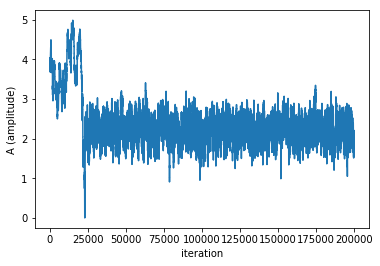

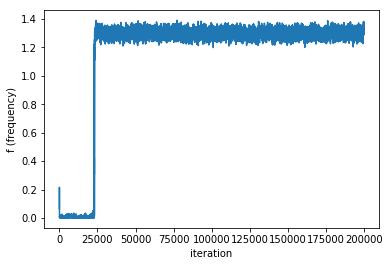

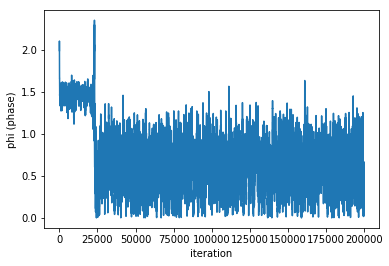

In [7]:
plt.plot(samples[:,0])
plt.xlabel('iteration')
plt.ylabel('A (amplitude)')
plt.show()

plt.plot(samples[:,1])
plt.xlabel('iteration')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(samples[:,2])
plt.xlabel('iteration')
plt.ylabel('phi (phase)')
plt.show()

上記のプロットを使用して、「バーンイン（チェーンが定常状態に落ち着く前）」として捨てるサンプル数を決定します

In [8]:
#After abour 25000 samples, the chains seem to have settled
burnin = 25000
samples = samples[burnin:]

異なるパラメータのサンプルをプロットします。 これは、パラメータ間の縮退および相関を明らかにする。 パラメータは相関していますか？

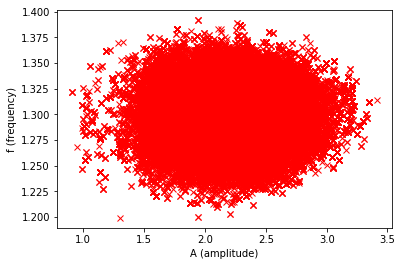

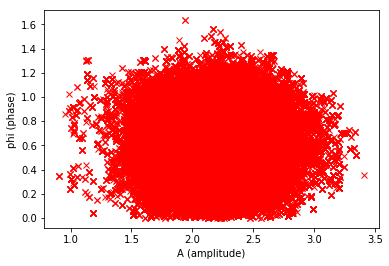

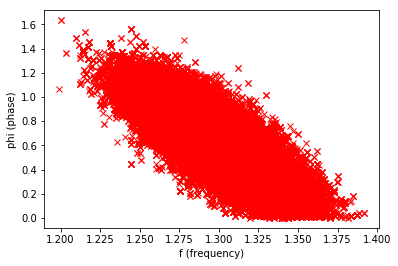

In [9]:
plt.plot(samples[:,0],samples[:,1],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(samples[:,0],samples[:,2],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('phi (phase)')
plt.show()

plt.plot(samples[:,1],samples[:,2],'x',color='red')
plt.xlabel('f (frequency)')
plt.ylabel('phi (phase)')
plt.show()


しかし、すべてのサンプルが独立しているとは限りません。 残りのサンプルの自己相関を計算する

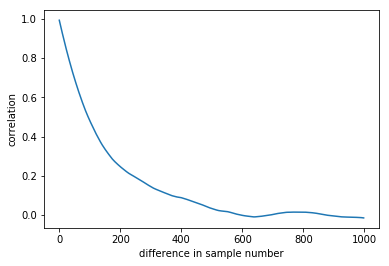

In [10]:
xmean=(np.mean(samples[:,0]))
xvar=(np.var(samples[:,0]))
ACL=np.array([(((samples[h:,0]-xmean)*(samples[:-h,0]-xmean)).sum())/(len(samples[:,0])-h)/xvar for h in range(1,1000)])                              

plt.plot(ACL)
plt.xlabel(r'difference in sample number')
plt.ylabel(r'correlation')
plt.show()

プロットを使用してサンプル間の相関長さを決定し、チェーンを「薄く」する

In [11]:
corrlength = 400 #where the correlation drops to about 0.1
independentsamples = samples[::corrlength]
print independentsamples.shape
print 'effective acceptance ratio:', 1.*independentsamples.shape[0]/Nsteps

(438, 3)
effective acceptance ratio: 0.00219


異なるパラメータのサンプルを再びプロットします。ここでは、*独立な* サンプルのみを使用します。

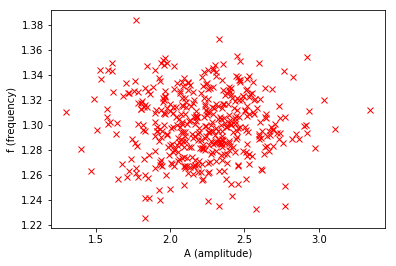

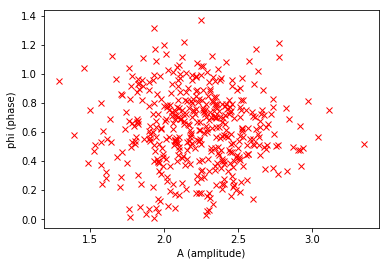

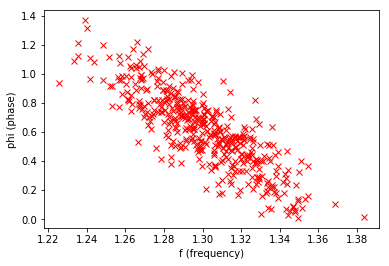

In [12]:
plt.plot(independentsamples[:,0],independentsamples[:,1],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(independentsamples[:,0],independentsamples[:,2],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('phi (phase)')
plt.show()

plt.plot(independentsamples[:,1],independentsamples[:,2],'x',color='red')
plt.xlabel('f (frequency)')
plt.ylabel('phi (phase)')
plt.show()


各パラメータの1次元事後確率は、他のすべてのパラメータに対してマージナライズすることによって得られる。 実際には、マージナライズされた事後確率はは、サンプルの正規化されたヒストグラムです。

/anaconda/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


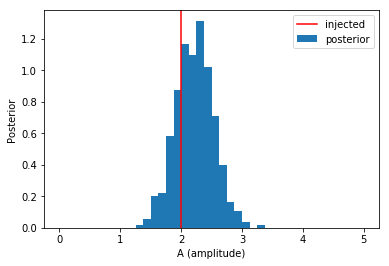

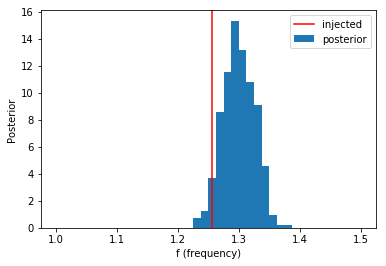

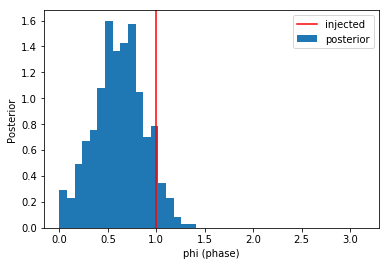

In [13]:
x_values = independentsamples[:,0]

plt.hist(x_values,range=(0,5),bins=40,normed=True,label='posterior')
plt.axvline(A,color='r',label='injected')
plt.xlabel('A (amplitude)')
plt.ylabel('Posterior')
plt.legend()
plt.show()

y_values = independentsamples[:,1]

plt.hist(y_values,range=(1,1.5),bins=40,normed=True,label='posterior')
plt.axvline(f,color='r',label='injected')
plt.xlabel('f (frequency)')
plt.ylabel('Posterior')
plt.legend()
plt.show()

z_values = independentsamples[:,2]

plt.hist(z_values,range=(0,np.pi),bins=40,normed=True,label='posterior')
plt.axvline(phi,color='r',label='injected')
plt.xlabel('phi (phase)')
plt.ylabel('Posterior')
plt.legend()
plt.show()

事後分布は、各パラメータの「真の」値に近くなりますが、正確な位置にピークしません。 **データからノイズを取り除き、チェーンを再実行してみてください。**

**3つの信号パラメータの平均、中央値、90％信頼区間を計算せよ**

**$A^2$（信号の2乗の振幅）の期待値を計算します。 ヒント：$<A^2> = \int A^2 p　(A|d)dA$**

データとそれらの90％信頼区間後のデータをプロットしましょう ([この論文](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.118.221101)のFig. 4の様に)

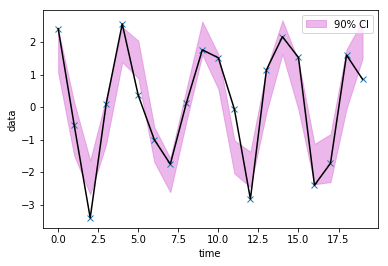

In [14]:
percentile5=np.zeros(len(t))
percentile95=np.zeros(len(t))
for time in t:
    d=model(independentsamples[:,0],independentsamples[:,1],independentsamples[:,2],time)
    percentile5[time] = np.percentile(d,5)
    percentile95[time] = np.percentile(d,95)

fig, ax = plt.subplots()    
ax.fill_between(t, percentile5, percentile95, color='orchid',alpha=0.5, label="90% CI")
plt.plot(data,'x')
plt.plot(data,'k')
plt.xlabel('time')
plt.ylabel('data')
plt.legend()
plt.show()

90％信頼区間にすべてのデータポイントが含まれているわけではありません。 **それで大丈夫ですか？**

実際には、開始値の異なる複数のチェーンを実行し、それらがすべて同じ領域に収束することを確認します。 **ランダムシードを変更してチェーンを再度実行する**

**パラメータを変更してチェーンを再度実行せよ**

これらのメソッドのいくつかが既に実装されているさまざまなPythonモジュールが存在します。例えば[emcee](http://dan.iel.fm/emcee/current/), [kombine](http://pages.uoregon.edu/bfarr/kombine/)